# Parallel Tempering implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def U(x):
    """Potential"""
    U = 1 + np.sin(2 * np.pi * x)

    if x < -2 or x > 2:
        return np.inf
    elif -1.25 <= x <= -0.25:
        U *= 2
    elif -0.25 <= x <= 0.75:
        U *= 3
    elif 0.75 <= x <= 1.75:
        U *= 4
    elif  1.75 <= x <= 2:
        U *= 5
    return U


Temperatures = np.array([0.05, 0.5, 2.0]) # k_B = 1
betas = 1/Temperatures

x_initial = -1.0

maximum_displacement = 0.1

parallel_tempering_after = 10


In [104]:
def MC_step(x, beta, displacement):
    """Perform a single Monte Carlo step based of precalculated displacement

    Args:
        x (float): Current position
        T (float): Temperature
        displacement (float): Displacement to apply

    Returns:
        tuple: New position and whether the move was accepted    
    """
    x_new = x + displacement
    U_x = U(x)
    U_x_new = U(x_new)

    if U_x_new < U_x:
        return x_new, True
    else:
        p_accept = np.exp(-(U_x_new - U_x) * beta)
        if np.random.rand() < p_accept:
            return x_new, True
        else:
            return x, False
        

        
def Parallel_Tempering_step(x1, x2, beta1, beta2):
    """Perform a parallel tempering step between two temperatures by swapping positions if accepted

    Args:
        x1 (float): Current position at temperature T1
        x2 (float): Current position at temperature T2
        beta1 (float): Inverse temperature 1 (1/T1)
        beta2 (float): Inverse temperature 2 (1/T2)

    Returns:
        whether the swap was accepted
    """
    U_x1 = U(x1)
    U_x2 = U(x2)

    

    p_swap = np.exp((beta1 - beta2) * (U_x1 - U_x2))
    if np.random.rand() < p_swap:
        return x2, x1, True
    else:
        return x1, x2, False


def precalculate_displacements(maximum_displacement, n_steps):
    """Precalculate displacements for the Monte Carlo steps

    Args:
        maximum_displacement (float): Maximum displacement allowed
        n_steps (int): Number of steps to precalculate

    Returns:
        np.ndarray: Array of displacements
    """
    return np.random.rand(n_steps) * maximum_displacement * 2 - maximum_displacement

def simulation(n_steps, betas = betas, x_initial = x_initial, parallel_tempering_after = parallel_tempering_after, maximum_displacement = maximum_displacement, parallel_tempering = True):
    """Run the Monte Carlo simulation"""

    n_temperatures = len(betas)
    displacements = [precalculate_displacements(maximum_displacement, n_steps) for i in range(n_temperatures)]

    x = np.full(n_temperatures, x_initial)
    energies = np.zeros((n_temperatures, n_steps))
    mc_acceptance_ratio = np.zeros(n_temperatures)
    swap_acceptance_ratio = np.zeros((n_temperatures, n_temperatures))
    
    single_trajectory = np.empty(n_steps)

    for step in range(n_steps):
        for i in range(n_temperatures):
            x_new, accepted = MC_step(x[i], betas[i], displacements[i][step])
            energies[i, step] = U(x_new)
            if accepted:
                x[i] = x_new
                mc_acceptance_ratio[i] += 1

        if step % parallel_tempering_after == 0 and step > 0 and parallel_tempering:
            # Perform parallel tempering step
            for i in range(n_temperatures - 1):
                x[i], x[i + 1], swap_accepted = Parallel_Tempering_step(x[i], x[i + 1], betas[i], betas[i + 1])
                swap_acceptance_ratio[i, i + 1] += swap_accepted
                swap_acceptance_ratio[i + 1, i] += swap_accepted

        single_trajectory[step] = x[0]  # Store the trajectory of the first temperature

    mc_acceptance_ratio /= n_steps
    swap_acceptance_ratio /= (n_steps // parallel_tempering_after)

    return energies, mc_acceptance_ratio, swap_acceptance_ratio, single_trajectory


def trajectory_histogram(trajectory, n_bins=100):
    """Plot histogram of the trajectory

    Args:
        trajectory (np.ndarray): Trajectory data
        n_bins (int): Number of bins for the histogram
    """
    plt.figure(figsize=(8, 4))
    plt.hist(trajectory, bins=n_bins, density=True, alpha=0.6, color='g', label='Trajectory Histogram')

    # Plot the potential energy for reference
    x = np.linspace(-2.5, 2.5, 1000)
    U_x = np.vectorize(U)(x)
    plt.plot(x, U_x, 'r-', lw=2, label='Potential Energy')
    plt.title('Trajectory Histogram')
    plt.xlabel('Position')
    plt.ylabel('Density')
    plt.grid()
    plt.legend()
    plt.show()



In [105]:

steps = 1e5

energies, mc_acceptance_ratio, swap_acceptance_ratio, single_trajectory = simulation(int(steps), parallel_tempering=True, x_initial = -1.)

print("Monte Carlo Acceptance Ratios:", mc_acceptance_ratio)
print("Swap Acceptance Ratios:\n", swap_acceptance_ratio)

Monte Carlo Acceptance Ratios: [0.32148 0.70021 0.85988]
Swap Acceptance Ratios:
 [[0.     0.3803 0.    ]
 [0.3803 0.     0.5469]
 [0.     0.5469 0.    ]]


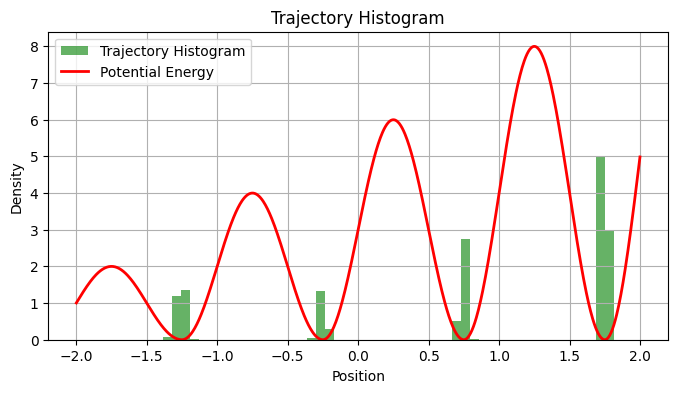

In [106]:
trajectory_histogram(single_trajectory, n_bins=50)

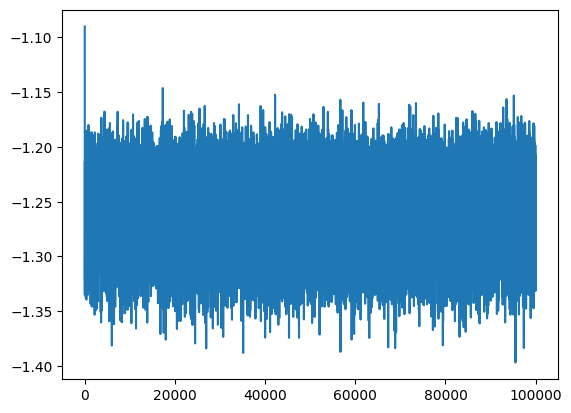

In [74]:
plt.plot(np.arange(steps), single_trajectory, label='Trajectory at T=0.05')